-1221.2276075781194

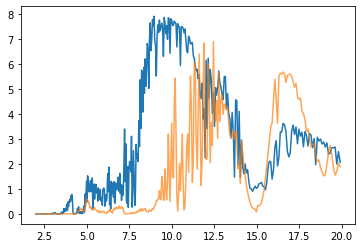

In [1]:
import getpass
import os
import numpy as np
import sys
import matplotlib.pyplot as plt
os.environ['OMP_NUM_THREADS'] = '1' # to avoid using too many CPUs

if getpass.getuser() == "grasser": # when running from LEM
    os.environ['pRT_input_data_path'] ="/net/lem/data2/pRT_input_data"
    from mpi4py import MPI 
    comm = MPI.COMM_WORLD # important for MPI
    rank = comm.Get_rank() # important for MPI
    import matplotlib
    matplotlib.use('Agg') # disable interactive plotting
    from LIFE_retrieval.target import Target
    from LIFE_retrieval.retrieval import Retrieval
    from LIFE_retrieval.parameters import Parameters
elif getpass.getuser() == "natalie": # when testing from my laptop
    os.environ['pRT_input_data_path'] = "/home/natalie/.local/lib/python3.8/site-packages/petitRADTRANS/input_data_std/input_data"
    from target import Target
    from retrieval import Retrieval
    from parameters import Parameters

test_object = 'test'
Nlive=100 # number of live points (integer)
evtol=10 # evidence tolerance (float)
bayes=False

def init_retrieval(obj,Nlive,evtol,PT_type='PTgrad'):

    output=f'{obj}_N{Nlive}_e{evtol}' # output folder name
    obj = Target(obj)

    constant_params={} # add if needed
    free_params = {'rv': ([0,20],r'$v_{\rm rad}$'),
                'log_g':([1,3],r'log $g$')}
    
    if PT_type=='PTknot':
        pt_params={'T0' : ([100,1000], r'$T_0$'), # bottom of the atmosphere (hotter)
                'T1' : ([0,1000], r'$T_1$'),
                'T2' : ([0,1000], r'$T_2$'),
                'T3' : ([0,1000], r'$T_3$'),
                'T4' : ([0,1000], r'$T_4$'),} # top of atmosphere (cooler)
        free_params.update(pt_params)

    if PT_type=='PTgrad':
        pt_params={'dlnT_dlnP_0': ([0.,0.4], r'$\nabla T_0$'), # gradient at T0 
                'dlnT_dlnP_1': ([0.,0.4], r'$\nabla T_1$'), 
                'dlnT_dlnP_2': ([0.,0.4], r'$\nabla T_2$'), 
                'dlnT_dlnP_3': ([0.,0.4], r'$\nabla T_3$'), 
                'dlnT_dlnP_4': ([0.,0.4], r'$\nabla T_4$'), 
                'T0': ([100,1000], r'$T_0$')} # at bottom of atmosphere
        free_params.update(pt_params)
        
    # free chemistry, define VMRs
    chemistry={'log_H2O':([-12,0],r'log H$_2$O'),
            'log_CO':([-12,0],r'log CO'),
            'log_CO2':([-12,0],r'log CO$_2$'),
            'log_CH4':([-12,0],r'log CH$_4$'),
            'log_NH3':([-12,0],r'log NH$_3$'),
            'log_HCN':([-12,0],r'log HCN'),
            'log_H2S':([-12,0],r'log H$_2$S'),
            'log_C2H2':([-12,0],r'log C$_2$H$_2$'),
            'log_CH3Cl':([-12,0],r'log CH$_3$Cl'),
            'log_SO2':([-12,0],r'log SO$_2$'),
            'log_OCS':([-12,0],r'log OCS')
            }
        
    cloud_props={'log_opa_base_gray': ([-10,3], r'log $\kappa_{\mathrm{cl},0}$'),  
                'log_P_base_gray': ([-6,3], r'log $P_{\mathrm{cl},0}$'), # pressure of gray cloud deck
                'fsed_gray': ([0,20], r'$f_\mathrm{sed}$')} # sedimentation parameter for particles
    
    free_params.update(cloud_props)
    free_params.update(chemistry)
    parameters = Parameters(free_params, constant_params)
    cube = np.random.rand(parameters.n_params)
    parameters(cube)
    retrieval=Retrieval(target=obj,parameters=parameters,output_name=output,PT_type=PT_type)

    return retrieval

retrieval=init_retrieval(test_object,Nlive,evtol)
retrieval.PMN_lnL()
#retrieval.run_retrieval(N_live_points=Nlive,evidence_tolerance=evtol,bayes=bayes)
